Epoch 1/20, Loss: 1.6755
Epoch 2/20, Loss: 1.2678
Epoch 3/20, Loss: 1.0342
Epoch 4/20, Loss: 0.8892
Epoch 5/20, Loss: 0.7596
Epoch 6/20, Loss: 0.6635
Epoch 7/20, Loss: 0.5835
Epoch 8/20, Loss: 0.5010
Epoch 9/20, Loss: 0.4306
Epoch 10/20, Loss: 0.3738
Epoch 11/20, Loss: 0.3357
Epoch 12/20, Loss: 0.2911
Epoch 13/20, Loss: 0.2450
Epoch 14/20, Loss: 0.2164
Epoch 15/20, Loss: 0.1872
Epoch 16/20, Loss: 0.1654
Epoch 17/20, Loss: 0.1461
Epoch 18/20, Loss: 0.1270
Epoch 19/20, Loss: 0.1133
Epoch 20/20, Loss: 0.1007


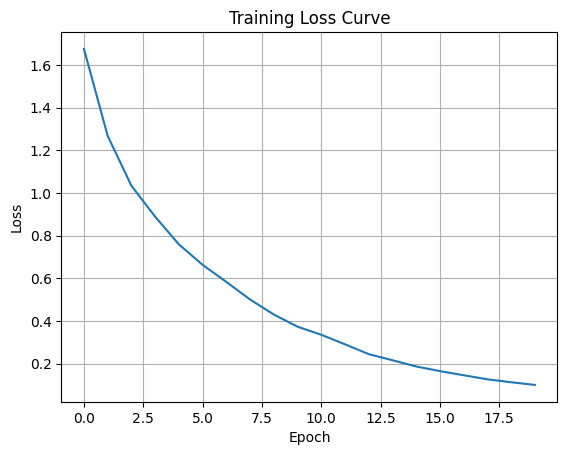

Model saved to sub3_dancemoves_model.pt


In [1]:
# CS506 Team Project TP03 – Deep Learning with PyTorch: Dance Move Detector
# Topic: Pose-based Dance Move Classification using CNN or LSTM
# Team Member: Veronica Elze

# =========================
# 🧩 STEP 0: Imports & Setup
# =========================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path
import os

# Reuse logic from previous submissions
from pose_tools_byH import poses_to_vectors

# ============================
# 📥 STEP 1: Load and Prepare Dataset
# ============================
class DancePoseDataset(Dataset):
    def __init__(self, poses_dir):
        self.samples = []
        self.labels = []
        self.label_dict = {}
        files = [f for f in os.listdir(poses_dir) if f.endswith('.json')]
        for idx, f in enumerate(files):
            label_name = f.split('_')[0]  # Extract label from filename
            if label_name not in self.label_dict:
                self.label_dict[label_name] = len(self.label_dict)

            try:
                with open(os.path.join(poses_dir, f), 'r') as file:
                    data = json.load(file)
                keypoints = data[0]['people'][0]['pose_keypoints_2d']
                keypoints = np.array(keypoints).reshape(-1, 3)[:, :2]
                self.samples.append(keypoints.flatten())
                self.labels.append(self.label_dict[label_name])
            except Exception as e:
                print(f"Skipping file {f} due to error: {e}")

        # Standardize features
        self.scaler = StandardScaler()
        self.samples = self.scaler.fit_transform(self.samples)
        self.samples = torch.tensor(self.samples, dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

# =====================================
# 🧠 STEP 2: Define Neural Network (CNN)
# =====================================
class DanceNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DanceNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

# ===========================
# 🎯 STEP 3: Train the Network
# ===========================
def train(model, dataloader, criterion, optimizer, epochs=20):
    loss_values = []
    for epoch in range(epochs):
        epoch_loss = 0
        for x, y in dataloader:
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(dataloader)
        loss_values.append(epoch_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
    return loss_values

# ===========================
# 📊 STEP 4: Visualization
# ===========================
def plot_loss_curve(losses):
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.grid(True)
    plt.show()

# ====================================
# 🚀 STEP 5: Main Execution Block
# ====================================
if __name__ == '__main__':
    try:
        poses_dir = Path("./poses")
        if not poses_dir.exists():
            raise FileNotFoundError(f"Could not find poses directory at {poses_dir}")

        dataset = DancePoseDataset(poses_dir)
        dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

        input_size = dataset.samples.shape[1]
        num_classes = len(dataset.label_dict)

        model = DanceNet(input_size, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        loss_history = train(model, dataloader, criterion, optimizer, epochs=20)
        plot_loss_curve(loss_history)

        model_save_path = Path("./sub3_dancemoves_model.pt")
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved to {model_save_path}")

    except Exception as e:
        print(f"Unhandled exception: {e}")

# ==============================
# REFERENCES
# ==============================
# OpenAI. (2025). ChatGPT’s assistance with CS506 TP03 Dance Detector [Large language model]. https://openai.com/chatgpt
# PyTorch. (n.d.). https://pytorch.org/docs/stable/index.html
# Scikit-Learn. (n.d.). StandardScaler. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html


## REFERENCES  
OpenAI. (2025). ChatGPT’s assistance with CS506 TP03 Dance Detector [Large language model]. https://openai.com/chatgpt  
PyTorch. (n.d.). https://pytorch.org/docs/stable/index.html